In [2]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sample_submit = pd.read_csv('gender_submission.csv')

In [4]:
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
def enhance_feature(df):
    # Age
    df['Age'][df['Age'].isnull()] = -1

    # Age_Label
    cut_points = [-2,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df['Age_Label'] = pd.cut(df['Age'], cut_points, labels=label_names)
    df['Age_Label'] = df['Age_Label'].astype(CategoricalDtype(categories=label_names, ordered=True))
    
    # Age_Label_Id
    df['Age_Label_Id'] = df['Age_Label'].map(dict(zip(label_names, range(len(label_names)))))

    # Embarked
    df['Embarked'] = df['Embarked'].astype('category')

    # Sex
    df['Sex'] = df['Sex'].astype('category')
    
    # Sex_Id
    df['Sex_Id'] = df['Sex'].map({'male':0,'female':1}) 
    
    # Title
    df['Title'] = df.Name.apply(lambda x: re.search(', (\w+)', x).group(1))
    df['Title'] = df['Title'].astype('category')

    # Title_Id
    df['Title_Id'] = df['Title'].cat.codes
    
    # TtlFamMbr
    df['TtlFamMbr'] = df['Parch'] + df['SibSp']
    
    # Clean-up Age
    mean_age_by_title = df[df['Age'] != -1].groupby(['Title'])['Age'].mean()
    df[df['Age'] == -1]['Age'] = None
    df['Age'] = df['Age'].fillna(df['Title'].map(mean_age_by_title))
    
    # Clean-up Embarked
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].value_counts().index[0])
    return df

In [6]:
df_train = enhance_feature(df_train)
df_test = enhance_feature(df_test)

In [7]:
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Label,Age_Label_Id,Sex_Id,Title,Title_Id,TtlFamMbr
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Young Adult,4,0,Mr,11,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adult,5,1,Mrs,12,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Young Adult,4,1,Miss,8,0


In [8]:
Feature_Cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_Id', 'Age_Label_Id', 'TtlFamMbr', 'Title_Id']
Target_Cols = ['Survived']

In [9]:
df_train[Feature_Cols + Target_Cols].head(3)

,Pclass,Age,SibSp,Parch,Fare,Sex_Id,Age_Label_Id,TtlFamMbr,Title_Id,Survived
0,3,22.0,1,0,7.2500,0,4,1,11,0
1,1,38.0,1,0,71.2833,1,5,1,12,1
2,3,26.0,0,0,7.9250,1,4,0,8,1


#### Looking at the correlation head map, "Pclass", "Title_Id", and "Sex_Id" have the strongest correlation to Survived

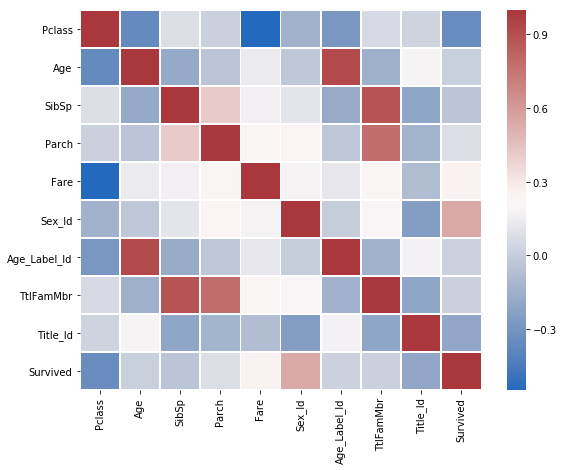

In [10]:
plt.figure(figsize=(9, 7))
sns.heatmap(df_train[Feature_Cols + Target_Cols].corr(), linewidths=0.75, cmap='vlag')

In [11]:
print('Total of columns in features:', len(Feature_Cols))

Total of columns in features: 9


#### Looking at the plots of encoded categorical values may be harder to understand unless you know what they are by heart

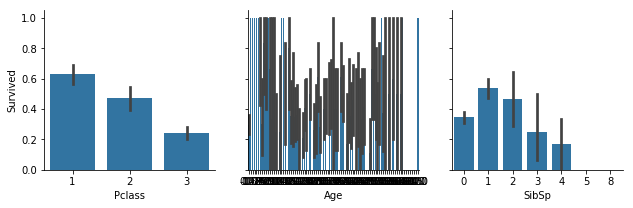

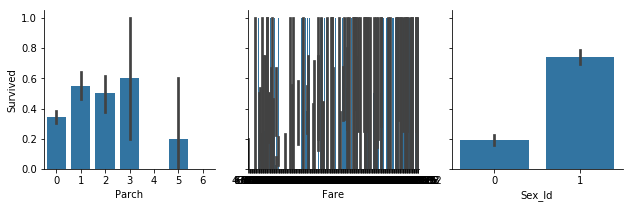

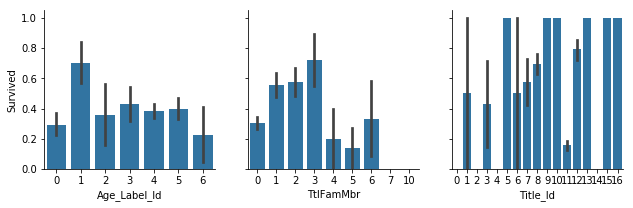

In [12]:
g = sns.PairGrid(df_train, x_vars=Feature_Cols[0:3], y_vars=Target_Cols, size=3)
g.map(sns.barplot)
g = sns.PairGrid(df_train, x_vars=Feature_Cols[3:6], y_vars=Target_Cols, size=3)
g.map(sns.barplot)
g = sns.PairGrid(df_train, x_vars=Feature_Cols[6:9], y_vars=Target_Cols, size=3)
g.map(sns.barplot)

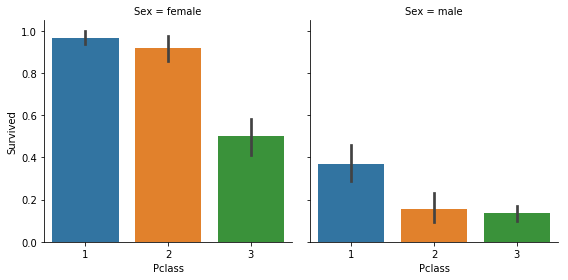

In [13]:
sns.factorplot(x='Pclass', y='Survived', col='Sex', data=df_train, kind='bar')

In [14]:
df_train[Feature_Cols + Target_Cols].to_csv('train_prepped.csv')
df_test[Feature_Cols].to_csv('test_prepped.csv')

In [215]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
model = LogisticRegression()

In [216]:
X_train, X_test, y_train, y_test = train_test_split(df_train[Feature_Cols], df_train[Target_Cols], 
                                                    test_size=0.3, random_state=21, stratify=df_train[Target_Cols])
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [217]:
pred = model.predict(X_test)

In [218]:
model.score(X_test, y_test)

0.7835820895522388

In [219]:
model.coef_

array([[-0.8099017 ,  2.68220692, -0.09844421, -0.27503007, -0.09423181,
         0.00510626]])

In [21]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
# from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

In [25]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = df_train[Target_Cols]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, df_train[Feature_Cols], df_train[Target_Cols], cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(df_train[Feature_Cols], df_train[Target_Cols])
    MLA_predict[MLA_name] = alg.predict(df_train[Feature_Cols])
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.898876,0.826493,0.0520853,0.0512398
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.940075,0.805597,0.0504229,0.0139372
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.942135,0.8,0.068677,0.0131364
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.826592,0.799254,0.0661869,0.0585561
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.95206,0.794403,0.0708769,0.0124369
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.796816,0.794403,0.0494188,0.144082
8,RidgeClassifierCV,"{'alphas': (0.1, 1.0, 10.0), 'class_weight': N...",0.793633,0.791045,0.0472277,0.00470688
19,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.793258,0.789925,0.0418992,0.00491817
17,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.95206,0.789552,0.0725801,0.00190511
11,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.78839,0.78806,0.0430061,0.00420868


### Submission to Kaggle for scoring